# Предсказание цен на недвижимость

### Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "MAE:\t" + str(round(mae(true_values, pred_values), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3)))
    
    plt.figure(figsize=(10,10))
    
    sns.scatterplot(x=pred_values, y=true_values)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

#### Описание датасета  

Id - идентификационный номер квартиры  
DistrictId - идентификационный номер района  
Rooms - количество комнат  
Square - площадь  
LifeSquare - жилая площадь  
KitchenSquare - площадь кухни  
Floor - этаж  
HouseFloor - количество этажей в доме  
HouseYear - год постройки дома  
Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности  
Social_1, Social_2, Social_3 - социальные показатели местности  
Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья  
Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров  
Price - цена квартиры  


#### указание пути к файлам

In [3]:
TEST = 'test.csv'
TRAIN = 'train.csv'
TEST_PREP = 'preptest.csv'
TRAIN_PREP = 'preptrain.csv'

##### создание датафрейма для обработки

In [4]:
df = pd.read_csv(TRAIN)

In [5]:
df_test = pd.read_csv(TEST)

In [6]:
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [7]:
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


In [9]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [ ]:
df_num_features = df.select_dtypes(include='float64')

### Обработка исходных данных

#### Исключаем признак ID

In [569]:
df = df[df.columns[1:]]

#### Поиск пустых значений

In [570]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(8), object(3)
memory usage: 1.4+ MB


#### замена пустых и экстремальных признаков Healthcare_1 на медианное значение

In [572]:
df.loc[df['Healthcare_1'].isnull(),'Healthcare_1'] = df['Healthcare_1'].mode()[0] 

In [579]:
df.loc[df['Rooms'] == 0, 'Rooms'] = df['Rooms'].median() ## спорная замена

In [580]:
df.loc[df['Rooms'] > 5, 'Rooms'] = df['Rooms'].median() ## спорная замена

In [582]:
df.loc[df['KitchenSquare'] > 100, 'KitchenSquare'] = df['KitchenSquare'].mode()[0]

In [583]:
df.loc[df['KitchenSquare'] > df['Square'],'KitchenSquare'] = df['KitchenSquare'].mode()[0]

In [584]:
df.loc[df['HouseYear'] > 2019, 'HouseYear'] = df['HouseYear'].mode()[0]

In [585]:
df.loc[df['Floor'] > df['HouseFloor'],'HouseFloor'] = df['Floor']

In [586]:
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,540.0,0,11,B,184966.930730
1,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [587]:
df.loc[df['Rooms'] == 0] 

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


In [588]:
df['Rooms'].value_counts()

2.0    3892
1.0    3705
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

In [589]:
df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.888400,56.315775,37.199645,5.825200,8.526700,13.435700,1984.782100,0.118858,24.687000,5352.157400,8.039200,853.630900,1.319500,4.231300,214138.857399
std,43.587592,0.811056,21.058732,86.241209,4.700942,5.241148,6.094012,18.349177,0.119025,17.532614,4006.799803,23.831875,795.934381,1.493601,4.806341,92872.293865
min,0.000000,1.000000,1.136859,0.370619,0.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,540.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,14.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,540.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,249135.462171
max,209.000000,5.000000,641.065193,7480.592129,96.000000,42.000000,117.000000,2019.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


##### вычисление отношения жилой прощади к нежилой у нормальных прощадей

In [590]:
df_norm = df[df['LifeSquare'].notnull() & (df['Square'] > df['LifeSquare'])]

In [591]:
df_norm['l/s'] = df_norm['Square']/ df_norm['LifeSquare']

In [592]:
df_norm

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,l/s
0,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,540.0,0,11,B,184966.930730,1.629656
1,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063,1.640060
2,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524,1.539439
3,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217,1.011786
4,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644,1.667602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9993,13,3.0,80.631333,48.899083,10.0,11,14.0,1999,0.090799,B,B,74,19083,2,540.0,5,15,B,350684.628560,1.648933
9995,32,2.0,50.401785,30.476203,5.0,6,6.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040,1.653808
9996,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,540.0,0,5,A,189050.289571,2.021574
9998,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808,1.288486


In [593]:
df[df['Square'] <= df['LifeSquare']]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
28,23,1.0,42.530043,43.967759,1.0,3,9.0,2014,0.034656,B,B,0,168,0,540.0,0,0,B,95338.198549
44,38,3.0,104.211396,106.340403,0.0,20,20.0,2017,0.060753,B,B,15,2787,2,520.0,0,7,B,435462.048070
52,1,2.0,61.400054,65.224603,0.0,17,22.0,2016,0.007122,B,B,1,264,0,540.0,0,1,B,199215.452229
123,25,3.0,85.952306,89.803753,1.0,4,4.0,2017,0.069753,B,B,53,13670,4,540.0,1,11,B,309688.592681
153,62,1.0,51.831473,53.491301,1.0,5,5.0,2015,0.072158,B,B,2,629,1,540.0,0,0,A,131797.472284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9884,30,2.0,59.015896,59.439082,12.0,5,5.0,2016,0.000078,B,B,22,6398,141,1046.0,3,23,B,126281.142781
9889,23,2.0,51.440463,53.134243,51.0,3,17.0,2017,0.005767,B,B,1,388,0,540.0,0,0,B,88150.012510
9895,27,3.0,123.430072,125.806981,1.0,5,10.0,2015,0.017647,B,B,2,469,0,540.0,0,0,B,234194.837047
9902,73,1.0,44.098768,44.267551,1.0,7,24.0,2014,0.042032,B,B,37,6856,84,1940.0,2,5,B,381937.404161


#### проверка где общая площадь меньше жилой

In [594]:
df[df['Square'] <= df['LifeSquare']]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
28,23,1.0,42.530043,43.967759,1.0,3,9.0,2014,0.034656,B,B,0,168,0,540.0,0,0,B,95338.198549
44,38,3.0,104.211396,106.340403,0.0,20,20.0,2017,0.060753,B,B,15,2787,2,520.0,0,7,B,435462.048070
52,1,2.0,61.400054,65.224603,0.0,17,22.0,2016,0.007122,B,B,1,264,0,540.0,0,1,B,199215.452229
123,25,3.0,85.952306,89.803753,1.0,4,4.0,2017,0.069753,B,B,53,13670,4,540.0,1,11,B,309688.592681
153,62,1.0,51.831473,53.491301,1.0,5,5.0,2015,0.072158,B,B,2,629,1,540.0,0,0,A,131797.472284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9884,30,2.0,59.015896,59.439082,12.0,5,5.0,2016,0.000078,B,B,22,6398,141,1046.0,3,23,B,126281.142781
9889,23,2.0,51.440463,53.134243,51.0,3,17.0,2017,0.005767,B,B,1,388,0,540.0,0,0,B,88150.012510
9895,27,3.0,123.430072,125.806981,1.0,5,10.0,2015,0.017647,B,B,2,469,0,540.0,0,0,B,234194.837047
9902,73,1.0,44.098768,44.267551,1.0,7,24.0,2014,0.042032,B,B,37,6856,84,1940.0,2,5,B,381937.404161


In [595]:
df_norm['l/s'].median()

1.637744365907453

#### замена площадей. 

In [598]:
df.loc[df['Square'] < df['LifeSquare'],'LifeSquare'] = df['Square']

In [599]:
df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.888400,56.315775,36.048753,5.825200,8.526700,13.435700,1984.782100,0.118858,24.687000,5352.157400,8.039200,853.630900,1.319500,4.231300,214138.857399
std,43.587592,0.811056,21.058732,19.372398,4.700942,5.241148,6.094012,18.349177,0.119025,17.532614,4006.799803,23.831875,795.934381,1.493601,4.806341,92872.293865
min,0.000000,1.000000,1.136859,0.370619,0.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.774881,22.765174,1.000000,4.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,540.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.513310,32.760108,6.000000,7.000000,14.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,540.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,65.900625,45.029599,9.000000,12.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,249135.462171
max,209.000000,5.000000,641.065193,638.163193,96.000000,42.000000,117.000000,2019.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


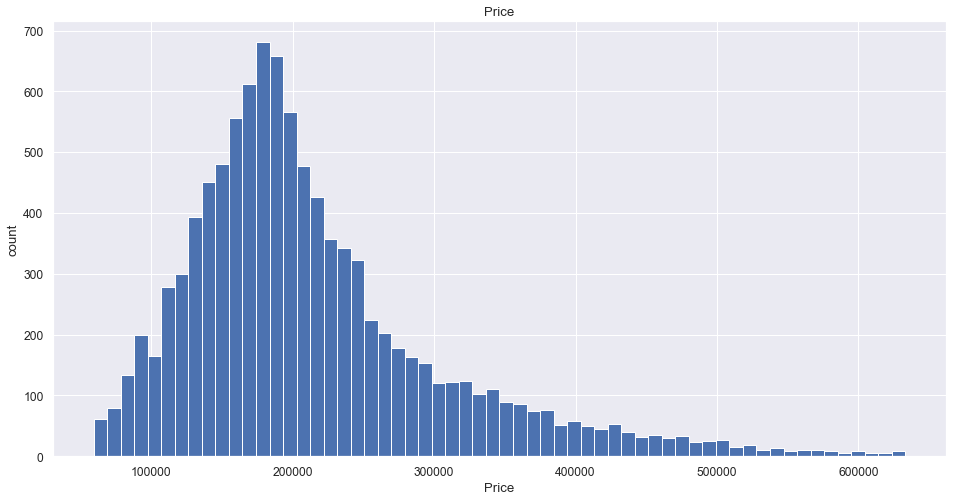

In [600]:
plt.figure(figsize = (16, 8))

df['Price'].hist(bins=60)
plt.ylabel('count')
plt.xlabel('Price')

plt.title('Price')
plt.show()

In [601]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     10000 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(8), object(3)
memory usage: 1.4+ MB


##### Приведение к бинарным признакам

In [602]:
df = pd.concat([df, pd.get_dummies(df[['Ecology_2', 'Ecology_3', 'Shops_2']])], axis=1)

In [603]:
df

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,...,0,11,B,184966.930730,0,1,0,1,0,1
1,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,...,1,16,B,300009.450063,0,1,0,1,0,1
2,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,...,1,3,B,220925.908524,0,1,0,1,0,1
3,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,...,0,5,B,175616.227217,0,1,0,1,0,1
4,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,...,2,4,B,150226.531644,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,32,2.0,50.401785,30.476203,5.0,6,6.0,1968,0.135650,B,...,3,11,B,196684.316040,0,1,0,1,0,1
9996,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,...,0,5,A,189050.289571,0,1,0,1,1,0
9997,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,B,...,0,0,A,159143.805370,0,1,0,1,1,0
9998,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,...,2,5,B,181595.339808,0,1,1,0,0,1


#### Отбор признаков

In [604]:
df.columns.tolist()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Ecology_2_A',
 'Ecology_2_B',
 'Ecology_3_A',
 'Ecology_3_B',
 'Shops_2_A',
 'Shops_2_B']

In [605]:
feature_names = ['DistrictId','Rooms','Square','KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Ecology_2_A',
 'Ecology_3_B',
 'Shops_2_A']

In [606]:
target_name = 'Price'

In [607]:
df = df[feature_names + [target_name]]
df.head()

,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_A,Ecology_3_B,Shops_2_A,Price
0,35,2.0,47.981561,6.0,7,9.0,1969,0.089040,33,5,540.0,0,11,0,1,0,184966.930730
1,41,3.0,65.683640,8.0,7,9.0,1978,0.000070,46,1,240.0,1,16,0,1,0,300009.450063
2,53,2.0,44.947953,0.0,8,12.0,1968,0.049637,34,0,229.0,1,3,0,1,0,220925.908524
3,58,2.0,53.352981,9.0,8,17.0,1977,0.437885,23,3,1084.0,0,5,0,1,0,175616.227217
4,99,1.0,39.649192,7.0,11,12.0,1976,0.012339,35,1,2078.0,2,4,0,1,0,150226.531644


#### Стандартизация признаков

In [608]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Social_1         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     10000 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Ecology_2_A      10000 non-null uint8
Ecology_3_B      10000 non-null uint8
Shops_2_A        10000 non-null uint8
Price            10000 non-null float64
dtypes: float64(7), int64(7), uint8(3)
memory usage: 1.1 MB


In [609]:
feature_names_for_stand = df[feature_names].columns.tolist()
feature_names_for_stand

['DistrictId',
 'Rooms',
 'Square',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Ecology_2_A',
 'Ecology_3_B',
 'Shops_2_A']

In [610]:
scaler = StandardScaler()
stand_features = scaler.fit_transform(df[feature_names_for_stand])

In [611]:
stand_features

array([[-0.35334758,  0.13760533, -0.39578028, ..., -0.09896975,
         0.16815955, -0.29986373],
       [-0.21568684,  1.37062805,  0.44486692, ..., -0.09896975,
         0.16815955, -0.29986373],
       [ 0.05963463,  0.13760533, -0.53984214, ..., -0.09896975,
         0.16815955, -0.29986373],
       ...,
       [-0.53689523, -1.09541738, -0.39780109, ..., -0.09896975,
         0.16815955,  3.33484814],
       [ 0.56439067,  0.13760533, -0.60373291, ..., -0.09896975,
        -5.94673325, -0.29986373],
       [ 1.78039385, -1.09541738, -0.83813275, ..., -0.09896975,
         0.16815955, -0.29986373]])

In [612]:
df[feature_names_for_stand] = pd.DataFrame(stand_features, columns=feature_names_for_stand)

In [613]:
df.head()

,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_A,Ecology_3_B,Shops_2_A,Price
0,-0.353348,0.137605,-0.395780,0.037186,-0.291306,-0.727915,-0.860142,-0.250529,0.474169,-0.127533,-0.394061,-0.883480,1.408356,-0.09897,0.16816,-0.299864,184966.930730
1,-0.215687,1.370628,0.444867,0.462654,-0.291306,-0.727915,-0.369632,-0.998053,1.215681,-0.295384,-0.770995,-0.213923,2.448700,-0.09897,0.16816,-0.299864,300009.450063
2,0.059635,0.137605,-0.539842,-1.239218,-0.100498,-0.235604,-0.914643,-0.581588,0.531208,-0.337347,-0.784816,-0.213923,-0.256195,-0.09897,0.16816,-0.299864,220925.908524
3,0.174352,0.137605,-0.140699,0.675388,-0.100498,0.584915,-0.424133,2.680470,-0.096225,-0.211458,0.289447,-0.883480,0.159943,-0.09897,0.16816,-0.299864,175616.227217
4,1.115034,-1.095417,-0.791473,0.249920,0.471924,-0.235604,-0.478634,-0.894969,0.588247,-0.295384,1.538356,0.455633,-0.048126,-0.09897,0.16816,-0.299864,150226.531644


#### Матрица корреляций

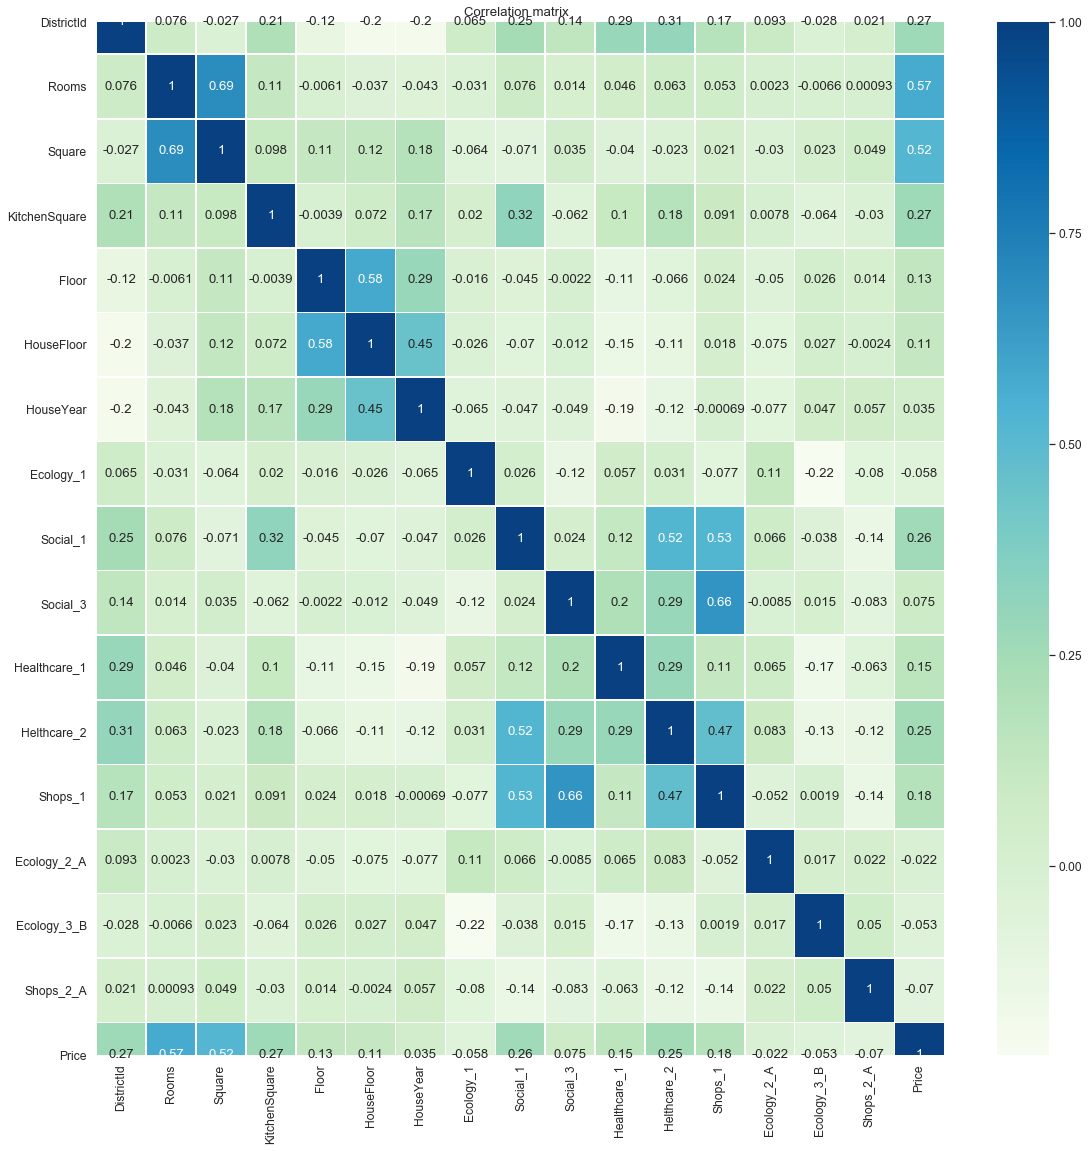

In [614]:
plt.figure(figsize = (19,19))

sns.set(font_scale=1.1)
sns.heatmap(df.corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix  ')
plt.show()

#### Сохранение обработанного обучающего датасета в csv

In [615]:
df.to_csv(TEST_PREP, index=False, encoding='utf-8')

#### Разбиение на train и test

In [616]:
x = df[feature_names]
y = df[target_name]

In [617]:
from sklearn.model_selection import train_test_split

In [618]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, shuffle=True, random_state=42)

## Построение базовых моделей и выбор лучшей

#### Линейная регрессия

In [619]:
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

R2:	0.523
MAE:	44025.951
MSE:	4085377825.148


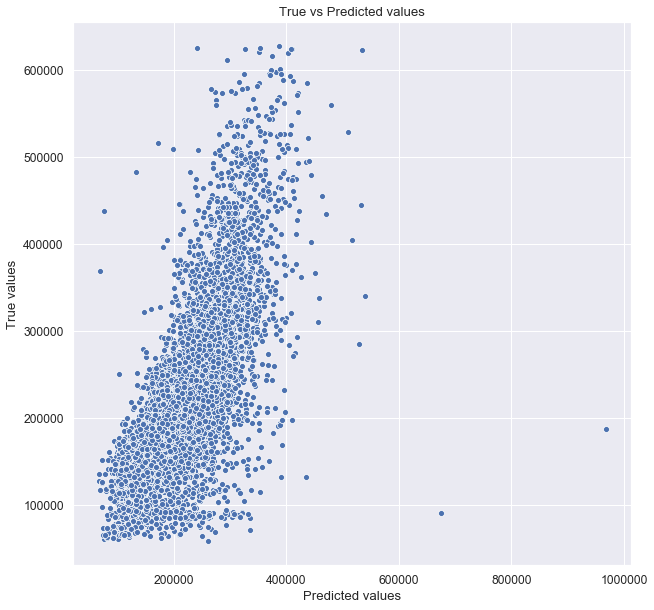

In [620]:
y_train_preds = lr_model.predict(x_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.474
MAE:	45138.141
MSE:	4636778663.594


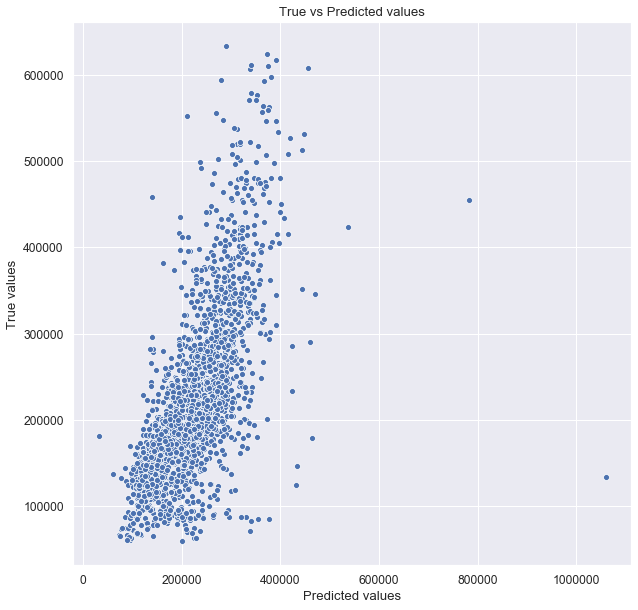

In [621]:
y_test_preds = lr_model.predict(x_test)
evaluate_preds(y_test, y_test_preds)

Text(0, 0.5, 'Признак')

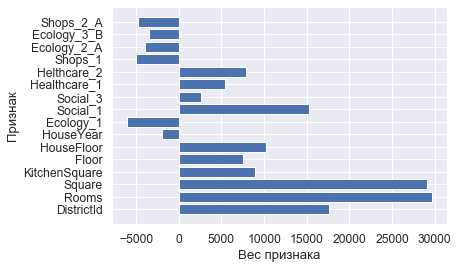

In [622]:
plt.barh(x_train.columns, lr_model.coef_.flatten())
plt.xlabel('Вес признака')
plt.ylabel('Признак')

#### Случайный лес

In [623]:
rf_model = RandomForestRegressor()
rf_model.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

R2:	0.948
MAE:	11790.249
MSE:	448896429.708


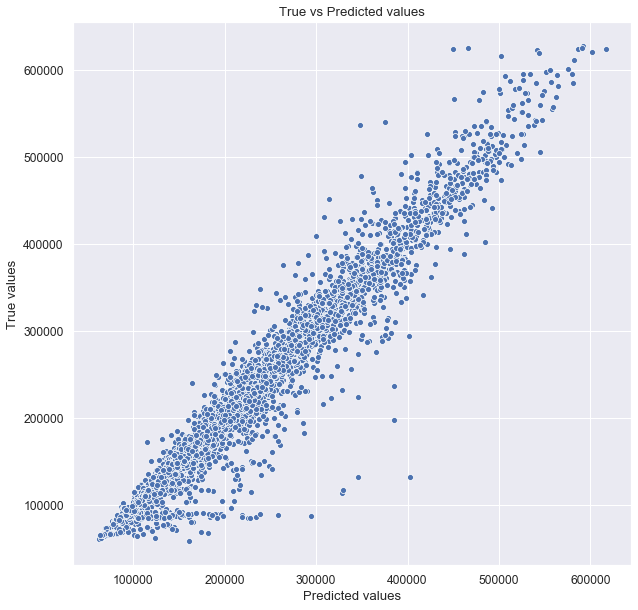

In [624]:
y_train_preds = rf_model.predict(x_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.702
MAE:	30487.769
MSE:	2623360778.979


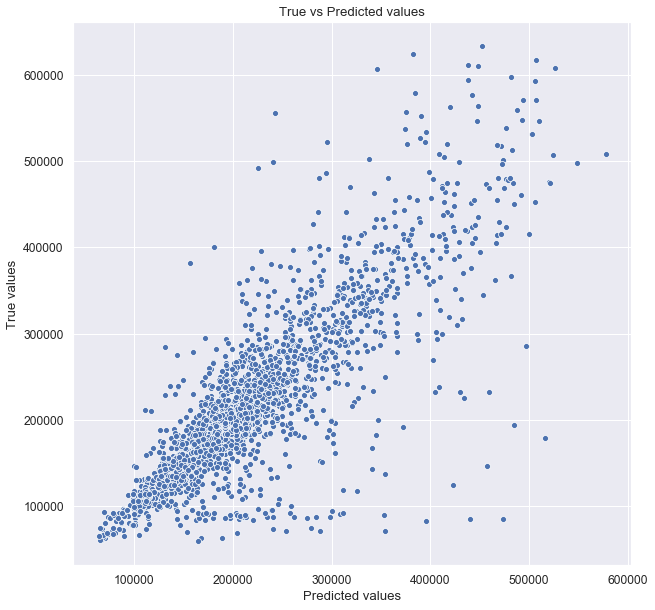

In [625]:
y_test_preds = rf_model.predict(x_test)
evaluate_preds(y_test, y_test_preds)